In [ ]:
! python -m pip install pyaudio

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
import string
import math
import scipy.signal as sgn

import pyaudio
import wave

from helpers import *

In [2]:
# CONSTANTS

Fs = 16000 # sampling freqency
TWOPI = 2 * np.pi
T=1 # transmission time per symbol

freq_shift = 0 # will be set to 1000 [Hz] if the channel is between 2000 and 3000 Hz, and left so if 1000->2000

# Pulse

WARNING : on utilise my_base entre les index 1 et 7 compris (les index 0 et 8 sont inutilisés !!!)

In [3]:
my_alphabet = list(' ' + string.printable) #our alphabet

#transforms a character from our alphabet to its binary representation
def toBinary(c):
    my_index = my_alphabet.index(c)
    toBinary = bin(my_index)
    return toBinary[2:] # we remove the header "0b"

In [4]:
number_bits = int(math.ceil(np.log2(len(my_alphabet)))) # the number of bits we require to represent our alphabet
my_base = np.linspace(1000, 2000, num= math.ceil(number_bits+2 )) # +2 because we dont need the borders (1000 and 2000)

base_distance = my_base[1] - my_base[0] # distance between 2 waves freqs

In [5]:
my_base

array([ 1000.,  1125.,  1250.,  1375.,  1500.,  1625.,  1750.,  1875.,
        2000.])

In [6]:
#adds to x a wave of frequency f
def wave(x,f,n):
    x += np.sin(TWOPI * (float(f + freq_shift)/Fs) * n) # If freq_shift=1000, all sines are shifted to the 1kHz-2kHz range.
    return x

#transforms a character from our alphabet to a distinct wave
def toWave(c):
    my_bin = toBinary(c)
    x = np.zeros(int(T * Fs))
    n = np.arange(len(x))
    for i in range(len(my_bin) -1, -1, -1):
        if(int(my_bin[i])):
            f = my_base[len(my_bin) - i] # because of the binary base
            x = wave(x, f, n)
    return x

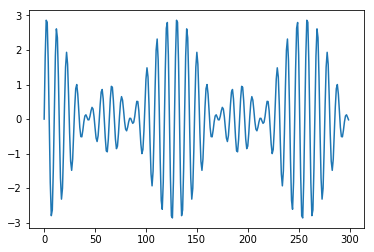

In [7]:
#You can test every character here (example with 'D')

x = toWave('T')
# the plot
plt.plot(x[0:300])
plt.show()

# we can play it:
IPython.display.Audio(x, rate=Fs)

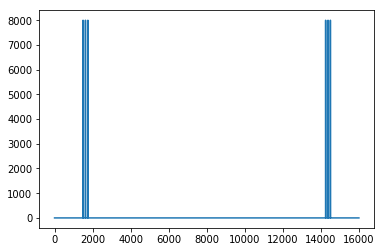

In [8]:
X = np.fft.fft(x, Fs)
plt.plot(np.abs(X))
plt.show()

On ferait peut etre mieux de générer les son avec le raised cosine aussi

# Emitter

In [9]:
# open the message file
my_text = open('message.txt', 'r')
my_message = my_text.read()
my_text.close

<function TextIOWrapper.close>

In [10]:
# array of our waves
my_message_waves = []
for i in range(len(my_message)):
    my_message_waves.append(toWave(my_message[i]))

In [11]:
# we generate the wave to be sent
to_be_sent = my_message_waves[0]
for i in range(1, len(my_message_waves)):
    to_be_sent = np.concatenate((to_be_sent, my_message_waves[i]))

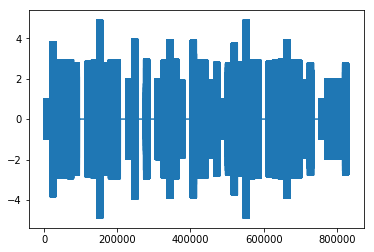

In [12]:
plt.plot(to_be_sent)
plt.show()

# we can play it:
IPython.display.Audio(to_be_sent, rate=Fs)

# Emitter + Reciever initial noise range detection

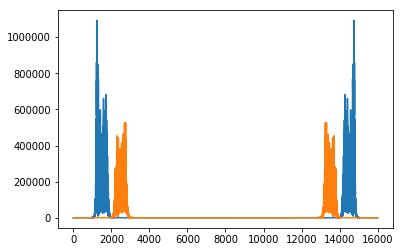

2

In [13]:
# Record initial noise !!

CHUNKSIZE = 2*T*Fs # 2 time slots

# initialize portaudio
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=Fs, input=True, frames_per_buffer=CHUNKSIZE)

# do this as long as you want fresh samples
data = stream.read(CHUNKSIZE)
numpydata = np.fromstring(data, dtype=np.int16)

noise = numpydata/1 # need to change the amplitude ??

# close stream
stream.stop_stream()
stream.close()
p.terminate()

# Check presence of silence between 1kHz and 2kHz
noise12 = butter_bandpass_filter(noise, 1200, 1800, Fs, order=10)
amplitude12 = np.mean(abs(noise12))

# Check presence of silence between 2kHz and 3kHz
noise23 = butter_bandpass_filter(noise, 2200, 2800, Fs, order=10)
amplitude23 = np.mean(abs(noise23))

# Plot
plt.plot(abs(np.fft.fft(noise12, Fs)))
plt.plot(abs(np.fft.fft(noise23, Fs)))
plt.show()

NOISE_RANGE=0 
if (abs(amplitude12) < abs(amplitude23)):
    NOISE_RANGE=1
else:
    NOISE_RANGE=2

if(NOISE_RANGE==2):
    freq_shift=1000
    
NOISE_RANGE # =1 if channel is free between 1kHz and 2kHz, =2 if 2kHz to 3kHz

# Reciever's audio recorder and chunker

In [25]:
# Record full stream at once.

CHUNKSIZE = 10*T*Fs # length of 10 symbols

# initialize portaudio
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=Fs, input=True, frames_per_buffer=CHUNKSIZE)

data = stream.read(CHUNKSIZE)
full_transmission = np.fromstring(data, dtype=np.int16)

stream.stop_stream()
stream.close()
p.terminate()

filtered_transmission = butter_bandpass_filter(full_transmission, 1000+freq_shift, 2000+freq_shift, Fs, order=12)

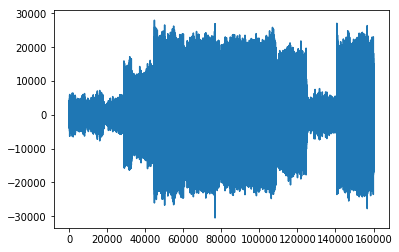

In [27]:
plt.plot(filtered_transmission)

In [28]:
begin = 0
max_t = np.max(filtered_transmission)
tresh = max_t/2

for i in range(0, len(filtered_transmission)):
    if(np.mean(filtered_transmission[i:i+1000]>tresh)):
        begin = i+1000
        break
        
filtered_transmission = filtered_transmission[begin:]

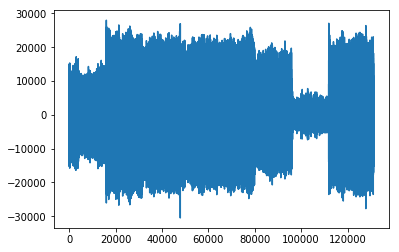

In [30]:
plt.plot(filtered_transmission)
IPython.display.Audio(filtered_transmission, rate=Fs)

In [ ]:
# Actual chunker
filter_symbol[] = # chunk filtered_transmission in some way !!!!!!

# Reciever's bandpass filter (apply to each chunk)

Mettre toute cette section et la suivante (cross) dans une boucle qui tournera pour chaque chunk reçu (1 chunk = 1 symbole) et tester chaque chunk sur quelles fréquences il contient.

In [ ]:
# rec_signal is an array of 7 signals corresponding to the filtered 7 frenquencies we may send

filtered_symbol = []

for i in range (1, 8):
    filtered_symbol.append(butter_bandpass_filter(raw_symbol, my_base[i]+freq_shift-base_distance/2, my_base[i]+freq_shift+base_distance/2, Fs, order=8))
    
plt.plot(abs(np.fft.fft(filtered_symbol[3], Fs)))

# Matched filter cross-correlation (1 per frequency)

In [ ]:
# TOY wave to test the code

#toy sent wave (3 freqs : 1000, 1200, 1400)
sig = raised_cosine(1000, T, Fs, beta=0.5) + raised_cosine(1200, T, Fs, beta=0.5) + raised_cosine(1400, 1, Fs, beta=0.5)

# noisy signal
sig_noise = sig + np.random.randn(len(sig)) # noiiiiiise

In [ ]:
# freqs we wanna check if present or not in the sent wave
freq_cosine = []

for i in range (1, 8):
    freq_cosine.append(raised_cosine(my_base[i], T, Fs, beta=0.5))

# x-corr to see if present in the signal
correlated_symbol = []

for i in range (0, 7):
    correlated_symbol.append(sgn.correlate(filtered_symbol[i], freq_cosine[i], mode='same'))
    
# Compute the average amplitude of the corss-correlation (of high, the freq is present, else it is not)
amplitude_symbol = []

for i in range (0, 7):
    amplitude_symbol.append(np.mean(abs(correlated_symbol[i])))
    
# Compute the max and the min of the amplitudes (of the amps are nearer to the max amp we say that the freq was sent, else not)
max_amp = np.max(amplitude_symbol)
min_amp = np.min(amplitude_symbol)

# Finally tell if freq present (1) or not (0)
decoded_symbol = []

for i in range (0, 7):
    decoded_symbol.append(1 if abs(amplitude_symbol[i] - max_amp) < abs(amplitude_symbol[i] - min_amp) else 0)